In [1]:
!pip install jaxopt

In [2]:
# Full JAX implementation with explicit GPU placement and precompiled inner BFGS.

import time
import numpy as np
import jax
import jax.numpy as jnp
from jax import device_put
from jaxopt import BFGS
import matplotlib.pyplot as plt

Choose dtype: set use_float64 = True for float64/complex128 (more precise, slower on many GPUs),
set to False to use float32/complex64 (faster on consumer GPUs).

In [3]:
use_float64 = True

# JAX x64 config
jax.config.update("jax_enable_x64", bool(use_float64))

# =========== Utility to pick dtype ===========
if use_float64:
    real_dtype = jnp.float64
    cplx_dtype = jnp.complex128
else:
    real_dtype = jnp.float32
    cplx_dtype = jnp.complex64

Check devices

In [4]:
print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())
gpu_devices = jax.devices("gpu")
if len(gpu_devices) > 0:
    gpu = gpu_devices[0]
    print("Using GPU device:", gpu)
else:
    gpu = jax.devices()[0]
    print("No GPU found; using device:", gpu)

JAX devices: [CudaDevice(id=0)]
Default backend: gpu
Using GPU device: cuda:0


In [5]:
class JAXGeneralizedLaserBeamShaper:
    """
    Matrix-based generalized projections with inner BFGS (JAX, GPU-aware).
    """

    def __init__(self, Dx, spatial_freq, n_elements, intensity_lb, intensity_ub, inner=4):
        self.M = int(n_elements)
        self.Dx = float(Dx)
        # Put arrays on chosen device with chosen dtype
        self.k = device_put(jnp.asarray(spatial_freq, dtype=real_dtype), device=gpu)
        self.lb = device_put(jnp.asarray(intensity_lb, dtype=real_dtype), device=gpu)
        self.ub = device_put(jnp.asarray(intensity_ub, dtype=real_dtype), device=gpu)
        self.inner = int(inner)

        # Build steering matrix A (K x M) in complex dtype and place on device
        n = jnp.arange(self.M, dtype=real_dtype) - (self.M // 2)
        A = (1.0 / jnp.sqrt(self.M)) * jnp.exp(1j * jnp.outer(self.k, n * self.Dx))
        self.A = device_put(A.astype(cplx_dtype), device=gpu)

        # Create inner solver once; the objective will accept (params_real, Sp) as args.
        # We'll define loss_fn(params_real, Sp) below and create solver with that signature.
        # Note: solver.run(initial_params, Sp) will be JIT-compiled.
        self._create_inner_solver()

    def _create_inner_solver(self):
        """
        Instantiate the BFGS solver object with a function of signature fun(params, Sp).
        We do not JIT-run here because Sp is a runtime argument; we'll jax.jit the solver.run later.
        """
        M = self.M
        A = self.A  # captured in closure

        def loss_fn(params_real, Sp):
            # params_real: concatenated [Re(c); Im(c)] length 2*M, real dtype
            re = params_real[:M]
            im = params_real[M:]
            c = re + 1j * im
            S = A @ c
            resid = (jnp.abs(S) ** 2 - jnp.abs(Sp) ** 2)
            return jnp.sum(resid ** 2)

        # Create solver object. fun(params, *args) is supported; we'll pass Sp as extra arg.
        self.inner_solver = BFGS(fun=loss_fn, maxiter=self.inner, tol=1e-6)

        # JIT-compile the solver.run for performance; it will be compiled on first call.
        # solver_run_jit(initial_params, Sp) -> returns dataclass with .params and .state
        self.solver_run_jit = jax.jit(self.inner_solver.run)

    def apply_intensity_constraints(self, focal_field: jnp.ndarray) -> jnp.ndarray:
        amp = jnp.abs(focal_field)
        phase = jnp.exp(1j * jnp.angle(focal_field))
        constrained_amp = jnp.clip(amp, self.lb, self.ub)
        return constrained_amp * phase

    def compute_focal_field(self, aperture_field: jnp.ndarray) -> jnp.ndarray:
        return self.A @ aperture_field

    def _complex_to_real(self, c: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([jnp.real(c).astype(real_dtype), jnp.imag(c).astype(real_dtype)])

    def _real_to_complex(self, r: jnp.ndarray) -> jnp.ndarray:
        M = self.M
        return r[:M].astype(cplx_dtype) + 1j * r[M:].astype(cplx_dtype)

    def compute_aperture_field(self, aperture_field_init: jnp.ndarray, constrained_focal: jnp.ndarray) -> jnp.ndarray:
        """
        Inner solve: use precompiled BFGS solver to minimize || |A c|^2 - |Sp|^2 ||^2
        - aperture_field_init: complex vector (length M) on the device
        - constrained_focal: complex vector (length K) on the device
        """
        # convert initial complex vector to real representation
        init_real = self._complex_to_real(aperture_field_init)

        # Warm call only if we haven't warmed yet. We'll store a flag.
        if not hasattr(self, "_inner_warm"):
            # Do a single warm run to force compilation. This may take some seconds.
            print("Warming & compiling inner BFGS solver (first run, may be slow)...")
            t0 = time.time()
            warm_res = self.solver_run_jit(init_real, constrained_focal)
            # ensure synchronous completion
            _ = jax.device_get(warm_res.params)
            t1 = time.time()
            print(f"Warm compile finished in {t1 - t0:.3f} s")
            self._inner_warm = True
            # We will ignore warm_res (it may be identical to first result), and continue to actual run below.

        # Call the JIT-compiled solver
        res = self.solver_run_jit(init_real, constrained_focal)
        params_real = res.params  # still on device
        # convert back to complex aperture field
        aperture_opt = self._real_to_complex(params_real)
        return aperture_opt

    def optimize_beam(self, max_iter=5000, tol=1e-12, verbose=True):
        # init aperture_field: pinv(A) @ lb like your original approach (put on device)
        init_vec = jnp.linalg.pinv(self.A) @ self.lb
        aperture_field = jnp.ones_like(init_vec, dtype=cplx_dtype)
        aperture_field = device_put(aperture_field, device=gpu)

        focal_field = self.compute_focal_field(aperture_field)
        norm = jnp.max(jnp.abs(focal_field))
        aperture_field = aperture_field / (norm + 1e-30)
        focal_field = focal_field / (norm + 1e-30)

        err_hist = []

        # Optional: compile a small JIT wrapper for one outer iteration (not required)
        for it in range(max_iter):
            prev = aperture_field

            # Apply focal-plane constraints
            constrained_focal = self.apply_intensity_constraints(focal_field)

            # Inner solve (BFGS)
            aperture_field = self.compute_aperture_field(aperture_field, constrained_focal)

            # Propagate to focal plane
            focal_field = self.compute_focal_field(aperture_field)

            # Normalize (avoid division by zero)
            norm = jnp.max(jnp.abs(focal_field))
            aperture_field = aperture_field / (norm + 1e-30)
            focal_field = focal_field / (norm + 1e-30)

            # Compute relative change (force synchronous evaluation of norm to be accurate)
            delta = jnp.linalg.norm(aperture_field - prev) / (jnp.linalg.norm(prev) + 1e-16)
            # block_until_ready to make the printed delta meaningful in time
            delta_val = float(delta.block_until_ready())
            err_hist.append(delta_val)

            if verbose and (it % 10 == 0):
                print(f"Iteration {it}: Δ = {delta_val:.3e}")

            if delta_val < tol:
                if verbose:
                    print(f"Converged after {it} iterations")
                break

        # store results (move to host numpy arrays)
        self.aperture_field = np.array(jax.device_get(aperture_field))
        self.focal_field = np.array(jax.device_get(focal_field))
        self.error_history = np.array(err_hist)
        return self.aperture_field, self.focal_field, self.error_history

Warming & compiling inner BFGS solver (first run, may be slow)...
Warm compile finished in 4.465 s
Iteration 0: Δ = 1.870e+00
Iteration 10: Δ = 1.001e-02
Iteration 20: Δ = 3.748e-03
Iteration 30: Δ = 2.815e-03
Iteration 40: Δ = 1.414e-03
Iteration 50: Δ = 1.280e-03
Iteration 60: Δ = 8.282e-04
Iteration 70: Δ = 6.660e-04
Iteration 80: Δ = 6.243e-04
Iteration 90: Δ = 4.893e-04
Iteration 100: Δ = 4.613e-04
Iteration 110: Δ = 3.710e-04
Iteration 120: Δ = 3.546e-04
Iteration 130: Δ = 3.041e-04
Iteration 140: Δ = 2.747e-04
Iteration 150: Δ = 2.575e-04
Iteration 160: Δ = 2.180e-04
Iteration 170: Δ = 2.073e-04
Iteration 180: Δ = 1.948e-04
Iteration 190: Δ = 1.878e-04
Total elapsed (wall) time: 10.748 s


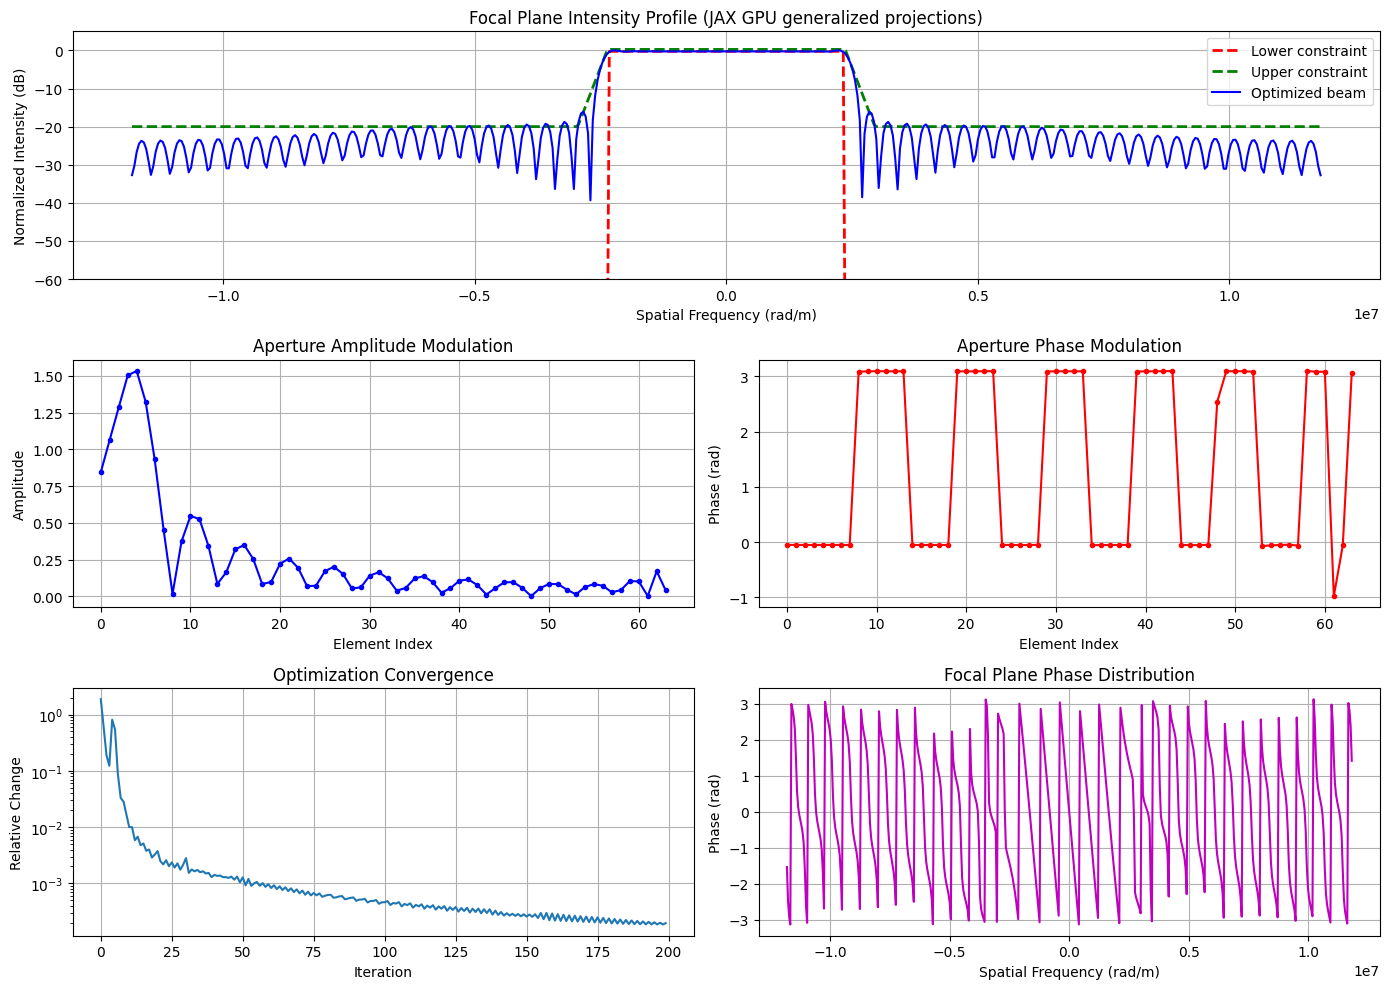


Beam shaping metrics:
Main lobe uniformity: 0.0070
Peak sidelobe level: -1.0 dB


In [6]:
if __name__ == "__main__":
    # Optical system parameters
    WAVELENGTH = 532e-9
    N_ELEMENTS = 64
    APERTURE_SIZE = (N_ELEMENTS - 1) * WAVELENGTH / 2.0
    Dx = APERTURE_SIZE / N_ELEMENTS

    # Spatial frequency domain (k-space)
    k_max = 2.0 * np.pi / WAVELENGTH
    ovs = 4
    k = np.linspace(-k_max, k_max, 2 * ovs * (N_ELEMENTS - 1))

    # desired top-hat with controlled sidelobes
    main_lobe_width = k_max / 5.0
    transition_width = k_max / 20.0

    # dB specs
    main_ripple_db = 0.25
    ub_outside_db = -20.0
    lb_floor_db = -100.0

    # convert to linear (amplitude)
    main_hi_lin = 10 ** (main_ripple_db / 20.0)
    main_lo_lin = 10 ** (-main_ripple_db / 20.0)
    ub_outside_lin = 10 ** (ub_outside_db / 20.0)
    lb_floor_lin = 10 ** (lb_floor_db / 20.0)

    intensity_lb = lb_floor_lin * np.ones_like(k)
    intensity_ub = ub_outside_lin * np.ones_like(k)

    main = np.abs(k) < main_lobe_width
    intensity_lb[main] = main_lo_lin
    intensity_ub[main] = main_hi_lin

    t = (np.abs(k) - main_lobe_width) / transition_width
    t = np.clip(t, 0.0, 1.0)
    ub_db = main_ripple_db + (ub_outside_db - main_ripple_db) * t
    ub_lin = 10 ** (ub_db / 20.0)
    in_trans = (t > 0.0) & (t < 1.0)
    intensity_ub[in_trans] = ub_lin[in_trans]

    # Build and run GPU shaper
    shaper = JAXGeneralizedLaserBeamShaper(
        Dx=Dx,
        spatial_freq=k,
        n_elements=N_ELEMENTS,
        intensity_lb=intensity_lb,
        intensity_ub=intensity_ub,
        inner=8,
    )

    # Run optimization (reduced outer iterations for test)
    t0 = time.time()
    aperture_field, focal_field, errors = shaper.optimize_beam(max_iter=200, tol=1e-10, verbose=True)
    # synchronize
    jax.device_get(aperture_field)
    elapsed = time.time() - t0
    print(f"Total elapsed (wall) time: {elapsed:.3f} s")

    # Visualization
    k_np = k
    ap_np = aperture_field
    fo_np = focal_field
    err_np = errors

    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, :])
    focal_intensity = np.abs(fo_np) ** 2
    focal_db = 10 * np.log10(focal_intensity / np.max(focal_intensity))
    ax1.plot(k_np, 20 * np.log10(intensity_lb), "r--", lw=2, label="Lower constraint")
    ax1.plot(k_np, 20 * np.log10(intensity_ub), "g--", lw=2, label="Upper constraint")
    ax1.plot(k_np, focal_db, "b-", label="Optimized beam")
    ax1.set_xlabel("Spatial Frequency (rad/m)")
    ax1.set_ylabel("Normalized Intensity (dB)")
    ax1.set_title("Focal Plane Intensity Profile (JAX GPU generalized projections)")
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(-60, 5)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(np.abs(ap_np), "b.-")
    ax2.set_xlabel("Element Index")
    ax2.set_ylabel("Amplitude")
    ax2.set_title("Aperture Amplitude Modulation")
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(np.angle(ap_np), "r.-")
    ax3.set_xlabel("Element Index")
    ax3.set_ylabel("Phase (rad)")
    ax3.set_title("Aperture Phase Modulation")
    ax3.grid(True)

    ax4 = fig.add_subplot(gs[2, 0])
    ax4.semilogy(err_np)
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Relative Change")
    ax4.set_title("Optimization Convergence")
    ax4.grid(True)

    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(k_np, np.angle(fo_np), "m-")
    ax5.set_xlabel("Spatial Frequency (rad/m)")
    ax5.set_ylabel("Phase (rad)")
    ax5.set_title("Focal Plane Phase Distribution")
    ax5.grid(True)

    plt.tight_layout()
    plt.show()

    # Diagnostics
    print("\nBeam shaping metrics:")
    print(f"Main lobe uniformity: {np.std(np.abs(fo_np[main])):.4f}")
    print(f"Peak sidelobe level: {10*np.log10(np.max(np.abs(fo_np[~main]) ** 2)):.1f} dB")
